In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pp
import os
import sys

parent = os.path.dirname(os.getcwd())  # workaround to import from utils/
sys.path.append(parent)

from utils.db_utils import df_from_snowflake
from utils.bayes import Bayesian_AB
pd.option_context('display.max_rows', None,)
pp.style.use('ggplot')

In [2]:
with open ('sql_template/revenue.sql', 'r') as sql_file:
    df = df_from_snowflake(sql_file.read())
df.set_index('DT', inplace=True)

In [3]:
df

,ID,USERS,SESSIONS,REVENUES,ONSITE_BOOKINGS,SEARCHES,UWOB,CUM_USERS,CUM_REVENUES,CUM_ONSITE_BOOKINGS,CUM_UWOB,RPU,ONSITE_BOOKING_PER_USER
DT,,,,,,,,,,,,,
2024-02-27,e3887v0,4256,4678,1849.146317,6.0000000000,12493,6,4256,1849.146317,6.0000000000,6,0.434480,0.001409774436
2024-02-27,e3887v1,4197,4592,1644.725151,8.0000000000,12246,8,4197,1644.725151,8.0000000000,8,0.391881,0.001906123421
2024-02-28,e3887v0,10651,12672,4198.333674,11.0000000000,30095,10,14907,6047.479990,17.0000000000,16,0.405681,0.001140403837
2024-02-28,e3887v1,10666,12781,3914.009828,19.0000000000,31007,18,14863,5558.734980,27.0000000000,26,0.373998,0.001816591536
2024-02-29,e3887v0,9757,11651,3083.483535,7.0000000000,29507,7,24664,9130.963526,24.0000000000,23,0.370214,0.000973078171
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-03,e3887v1,19492,23190,7479.057350,32.0000000000,58017,30,1560719,547466.414920,2683.0000000000,2619,0.350778,0.001719079476
2024-06-04,e3887v0,17714,21130,4221.917224,19.0000000000,52632,19,1568288,531624.126849,2457.0000000000,2410,0.338984,0.001566676529
2024-06-04,e3887v1,18038,21657,8393.882578,37.0000000000,55399,37,1578757,555860.297498,2720.0000000000,2656,0.352087,0.001722874388


In [4]:
df.drop(df[df['USERS']=='e3887v0'].index, inplace=True)

In [5]:
control = df.loc[df['ID']=='e3887v0',['USERS','ONSITE_BOOKINGS']]
treatment = df.loc[df['ID']=='e3887v1',['USERS','ONSITE_BOOKINGS']]

In [6]:
treatment, control

(            USERS ONSITE_BOOKINGS
 DT                               
 2024-02-27   4197    8.0000000000
 2024-02-28  10666   19.0000000000
 2024-02-29   9819   15.0000000000
 2024-03-01   8087    9.0000000000
 2024-03-02  14268   24.0000000000
 ...           ...             ...
 2024-06-01  17901   19.0000000000
 2024-06-02  24191   46.0000000000
 2024-06-03  19492   32.0000000000
 2024-06-04  18038   37.0000000000
 2024-06-05  17279   17.0000000000
 
 [100 rows x 2 columns],
             USERS ONSITE_BOOKINGS
 DT                               
 2024-02-27   4256    6.0000000000
 2024-02-28  10651   11.0000000000
 2024-02-29   9757    7.0000000000
 2024-03-01   8116   16.0000000000
 2024-03-02  14258   34.0000000000
 ...           ...             ...
 2024-06-01  17515   24.0000000000
 2024-06-02  23731   46.0000000000
 2024-06-03  18870   18.0000000000
 2024-06-04  17714   19.0000000000
 2024-06-05  17157   28.0000000000
 
 [100 rows x 2 columns])

In [7]:
E = Bayesian_AB(project_name='e3887-mobile',
                date_column='DT',
                sample_column='USERS',
                conversion_column='ONSITE_BOOKINGS',
                alpha_prior=1, 
                beta_prior=1,
                day_index=True,
                simulations= 1
            )

In [8]:
simulation_ImSa = E.posterior_analytic_importance_sampling(control=control,
                                                           variant=treatment)
simulation_ImSa

,simulations,day,variant_expected_loss,control_expected_loss,prob_variant_better_than_control,prob_variant_better_control_error,control_cvr,control_cvr_lower,control_cvr_upper,variant_cvr,variant_cvr_lower,variant_cvr_upper
0,1,0,1.741914e-04,0.000670,0.702556,0.000945,0.001644,0.000661,0.003065,0.002143,0.000981,0.003751
1,1,1,1.333638e-05,0.000689,0.933888,0.000736,0.001207,0.000716,0.001825,0.001884,0.001252,0.002642
2,1,2,1.595826e-06,0.000730,0.985728,0.000630,0.001014,0.000656,0.001447,0.001742,0.001261,0.002299
3,1,3,1.833308e-05,0.000355,0.875181,0.000773,0.001251,0.000898,0.001661,0.001587,0.001185,0.002046
4,1,4,9.367355e-05,0.000115,0.532312,0.000826,0.001594,0.001254,0.001975,0.001616,0.001273,0.001998
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,95,1.440807e-08,0.000143,0.998713,0.000551,0.001575,0.001512,0.001639,0.001718,0.001653,0.001784
96,1,96,1.605430e-08,0.000140,0.999470,0.000550,0.001581,0.001518,0.001644,0.001721,0.001656,0.001787
97,1,97,8.729495e-09,0.000147,0.999068,0.000549,0.001573,0.001511,0.001636,0.001720,0.001655,0.001785
98,1,98,3.510318e-09,0.000156,0.999829,0.000547,0.001567,0.001506,0.001630,0.001724,0.001659,0.001789


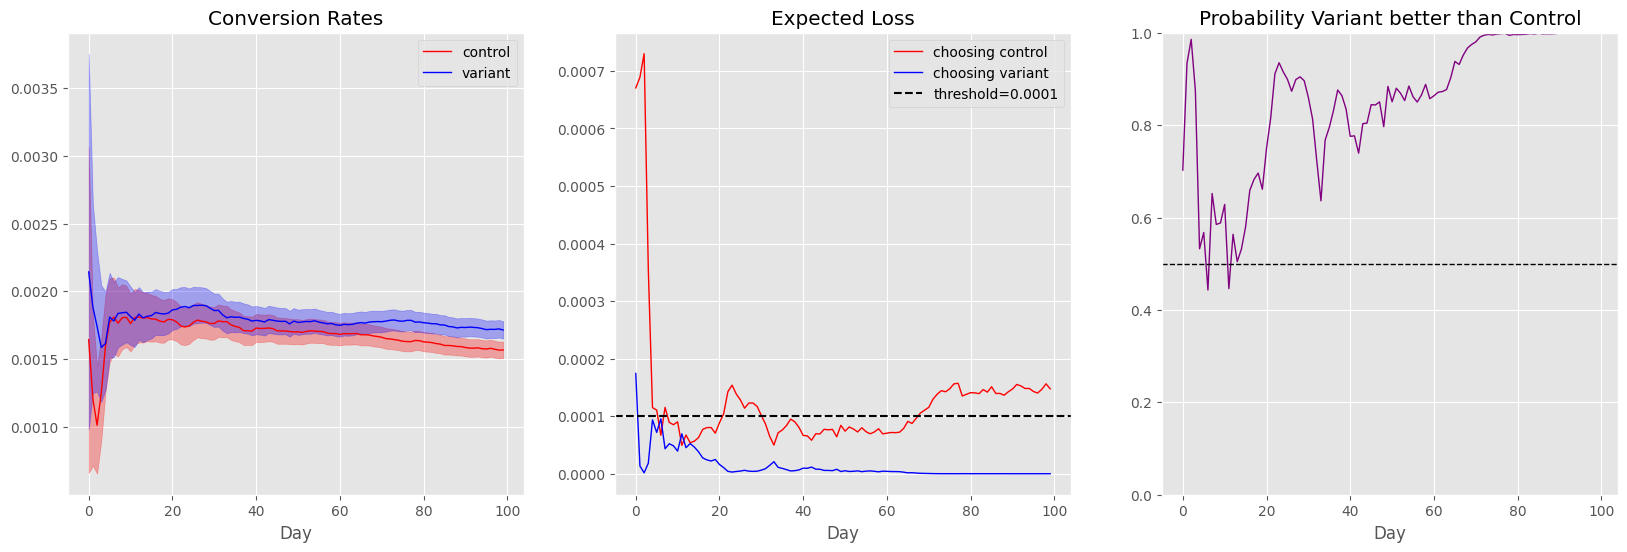

In [9]:
E.plot_expected_loss(simulation_ImSa)

In [ ]:
E.get_results()

### SUBSCRIPTION

In [13]:
with open ('sql_template/subscription_rate.sql', 'r') as sql_file:
    crm = df_from_snowflake(sql_file.read())
    
crm.sort_values(by='DT', ignore_index=True, inplace=True)
crm.set_index('DT', inplace=True)

In [14]:
control_2 = crm.loc[df['ID']=='e3887v0',['COOKIE_USER_IDS','SUBSCRIBERS']]
treatment_2 = crm.loc[df['ID']=='e3887v1',['COOKIE_USER_IDS','SUBSCRIBERS']]

In [15]:
E = Bayesian_AB(project_name='e3887-mobile',
                date_column='DT',
                sample_column='COOKIE_USER_IDS',
                conversion_column='SUBSCRIBERS',
                alpha_prior=1, 
                beta_prior=1,
                day_index=True,
                simulations= 1
            )
simulation_2 = E.posterior_analytic_importance_sampling(control=control_2,
                                                           variant=treatment_2)
simulation_2

,simulations,day,variant_expected_loss,control_expected_loss,prob_variant_better_than_control,prob_variant_better_control_error,control_cvr,control_cvr_lower,control_cvr_upper,variant_cvr,variant_cvr_lower,variant_cvr_upper
0,1,0,0.000943,9.813527e-04,0.505967,0.000816,0.013675,0.010549,0.017194,0.013714,0.010556,0.017272
1,1,1,0.001843,4.212925e-05,0.075258,0.000310,0.014696,0.012959,0.016538,0.012892,0.011269,0.014622
2,1,2,0.002826,5.499722e-07,0.001915,0.000030,0.015550,0.014158,0.017005,0.012724,0.011469,0.014042
3,1,3,0.002091,1.929693e-06,0.006938,0.000068,0.015305,0.014107,0.016551,0.013214,0.012103,0.014372
4,1,4,0.001812,1.377547e-06,0.005969,0.000062,0.015511,0.014499,0.016556,0.013698,0.012748,0.014681
...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,95,0.000306,5.673206e-07,0.012038,0.000097,0.017030,0.016842,0.017219,0.016724,0.016537,0.016912
96,1,96,0.000304,5.569515e-07,0.011851,0.000096,0.017032,0.016846,0.017220,0.016728,0.016543,0.016915
97,1,97,0.000265,1.212320e-06,0.023975,0.000152,0.017021,0.016836,0.017207,0.016757,0.016573,0.016943
98,1,98,0.000229,2.399790e-06,0.044037,0.000223,0.017011,0.016827,0.017196,0.016784,0.016601,0.016968


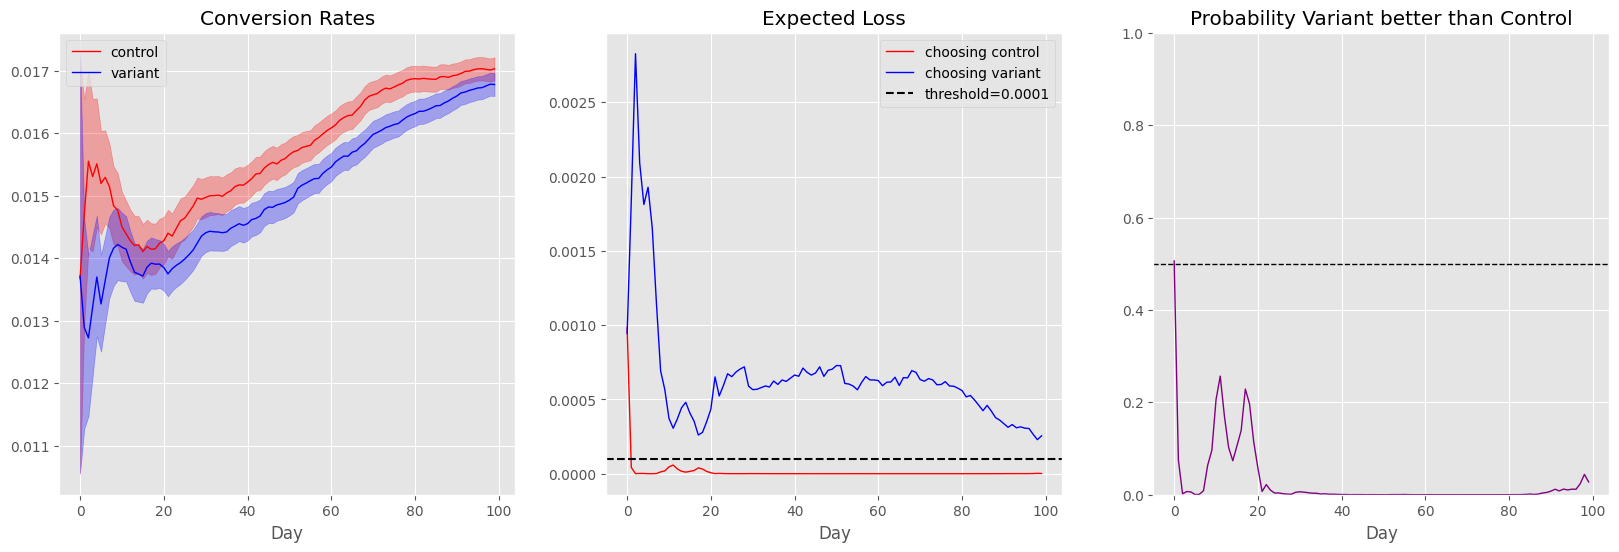

In [16]:
E.plot_expected_loss(simulation_2)

In [17]:
E.get_results()

VALUE
GROUP   METRIC                                       
control CvR                                   0.01703
        95% credible interval      (0.01685, 0.01722)
variant CvR                                   0.01678
        95% credible interval      (0.01660, 0.01696)
outcome uplift                                -1.488%
        control expected loss                0.000001
        variant expected loss                0.000255
        prob (variant >= control)              2.772%
        standard error                       0.000166